# Transportation Network Analysis with City2Graph

This notebook demonstrates the power of **City2Graph** for processing and analyzing public transportation networks. We'll use the General Transit Feed Specification (GTFS) data format to showcase how City2Graph transforms complex transit schedules into intuitive graph representations suitable for:

- **Urban accessibility analysis** - Understanding travel patterns and reachability
- **Network visualization** - Creating compelling maps of transit flows
- **Graph neural networks** - Converting transportation data into ML-ready formats
- **Spatial analysis** - Examining the relationship between transit and urban morphology

The City2Graph library simplifies the complex process of converting GTFS data into actionable insights, making transportation network analysis accessible to researchers, planners, and data scientists.

## 1. Environment Setup and Dependencies

Before we dive into transportation analysis, let's import the necessary libraries. City2Graph integrates seamlessly with the geospatial Python ecosystem, building on familiar tools like GeoPandas, Shapely, and NetworkX.

In [ ]:
# Geospatial data processing
import geopandas as gpd
import networkx as nx
import rustworkx as rx
import pandas as pd

# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Network analysis
import osmnx as ox

# Others
from pathlib import Path

# The star of the show: city2graph for transportation network analysis
import city2graph as c2g

city2graph version: 0.1.7


## 2. Loading GTFS Data with City2Graph

### What is GTFS?
The General Transit Feed Specification (GTFS) is the global standard for public transportation schedules and geographic information. GTFS data contains multiple interconnected tables describing:
- **Routes**: Transit lines (bus routes, train lines, etc.)
- **Stops**: Physical locations where passengers board/alight
- **Trips**: Individual vehicle journeys along routes
- **Stop times**: Scheduled arrival/departure times at each stop
- **Calendar**: Service patterns (weekdays, weekends, holidays)

### City2Graph's GTFS Advantage
While GTFS data is powerful, it's typically stored as separate CSV files that require complex joins and processing. **City2Graph simplifies this workflow by:**

1. **Automatic parsing** of zipped GTFS files
2. **Spatial integration** - converting coordinates to proper GeoDataFrames
3. **Data validation** and type coercion for reliable analysis
4. **Seamless integration** with the Python geospatial stack with compatibility to GeoDataFrame, nx.MultiGraph, PyTorch Geometric Data(), etc.

Let's see this in action with Transport for London data:

In [2]:
# Load GTFS data
sample_gtfs_path = Path("./data/itm_london_gtfs.zip")

print("Loading London Transport GTFS data...")

# One function call loads and processes the entire GTFS dataset
gtfs_data = c2g.load_gtfs(sample_gtfs_path)

print(f"Found {len(gtfs_data)} data tables")
print(f"Total stops: {len(gtfs_data['stops']):,}")
print(f"Total routes: {len(gtfs_data['routes']):,}")
print(f"Total scheduled stop times: {len(gtfs_data['stop_times']):,}")

Loading London Transport GTFS data...
Found 10 data tables
Total stops: 24,745
Total routes: 1,087
Total scheduled stop times: 17,807,603


### Understanding the GTFS Data Structure

City2Graph's `load_gtfs()` function returns a dictionary where each key corresponds to a GTFS table. The stops table is automatically converted to a GeoDataFrame with proper spatial coordinates, making it immediately ready for geospatial analysis.

Let's explore each component to understand how transit systems are structured:

- **calendar**: This table provides the service schedules for the transit agency. It indicates the days of the week and dates when services are available.
- **trip**: This table gives details about individual trips, including the route, service times, and other trip-specific information.
- **route**: This table contains information about the routes that are part of the transit system, such as the route number and description.
- **stop_times**: This table lists the times that vehicles stop at each stop on a trip, allowing for precise tracking of transit schedules.

Together, these components offer a comprehensive view of the transit system's operations, enabling effective analysis and visualization.

In [3]:
# Explore the structure of our GTFS data
print("Available GTFS tables:")
for i, table_name in enumerate(gtfs_data.keys(), 1):
    num_records = len(gtfs_data[table_name])
    print(f"  {i}. {table_name}: {num_records:,} records")

print("\n" + "="*50)
print("GTFS Table Descriptions:")
print("="*50)
print("agency      - Transit operators (TfL, etc.)")
print("calendar    - Service patterns (weekdays/weekends)")
print("routes      - Transit lines (Central Line, Bus 25, etc.)")
print("stops       - Physical stop locations (with coordinates)")
print("stop_times  - Scheduled arrivals/departures")
print("trips       - Individual vehicle journeys")
print("calendar_dates - Service exceptions (holidays, etc.)")

gtfs_data.keys()

Available GTFS tables:
  1. agency: 56 records
  2. stops: 24,745 records
  3. routes: 1,087 records
  4. calendar: 576 records
  5. calendar_dates: 40,264 records
  6. trips: 488,935 records
  7. shapes: 147,172 records
  8. frequencies: 61 records
  9. feed_info: 1 records
  10. stop_times: 17,807,603 records

GTFS Table Descriptions:
agency      - Transit operators (TfL, etc.)
calendar    - Service patterns (weekdays/weekends)
routes      - Transit lines (Central Line, Bus 25, etc.)
stops       - Physical stop locations (with coordinates)
stop_times  - Scheduled arrivals/departures
trips       - Individual vehicle journeys
calendar_dates - Service exceptions (holidays, etc.)


dict_keys(['agency', 'stops', 'routes', 'calendar', 'calendar_dates', 'trips', 'shapes', 'frequencies', 'feed_info', 'stop_times'])

In [4]:
# Agency information - Who operates the transit services?
print("Transit Agencies:")
print("This table contains information about transportation operators")
gtfs_data['agency'].head()

Transit Agencies:
This table contains information about transportation operators


agency_id                           agency_name                  agency_url  \
0   OP11949                          Golden Tours  https://www.traveline.info   
1   OP14145                          Quality Line  https://www.traveline.info   
2   OP14161              London Underground (TfL)  https://www.traveline.info   
3   OP14162               NATIONAL EXPRESS OPERAT  https://www.traveline.info   
4   OP14163  London Docklands Light Railway - TfL  https://www.traveline.info   

  agency_timezone agency_lang agency_phone agency_noc  
0   Europe/London          EN          NaN       GTSL  
1   Europe/London          EN          NaN       QULN  
2   Europe/London          EN          NaN       LULD  
3   Europe/London          EN          NaN         SS  
4   Europe/London          EN          NaN       LDLR

In [5]:
gtfs_data['calendar'].head()

service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0          1    True     True       True      True    True      True   False   
1          2    True     True       True      True    True     False   False   
2          3   False    False      False     False   False      True   False   
3         19   False    False      False     False   False     False    True   
4         21    True     True       True      True    True     False   False   

  start_date  end_date  
0   20250530  20260228  
1   20250530  20260228  
2   20250530  20260228  
3   20250530  20260228  
4   20250530  20260228

In [6]:
gtfs_data['calendar_dates'].head()

service_id      date exception_type
0      20458  20250903              1
1      31969  20251001              2
2      31438  20250711              2
3      20583  20251105              1
4      33097  20251201              1

In [7]:
gtfs_data['routes'].head()

route_id agency_id route_short_name route_long_name  route_type
0       58    OP5050              025             NaN         200
1       89    OP5050              444             NaN         200
2      100    OP5050              007             NaN         200
3      116    OP5050              022             NaN         200
4      289      OP53              372             NaN           3

In [8]:
# Stops - The spatial foundation of transit networks
print("Transit Stops (with Spatial Coordinates):")
print("Notice how city2graph automatically creates a 'geometry' column")
print("This makes stops immediately ready for geospatial analysis")
print(f"Coordinate Reference System: {gtfs_data['stops'].crs}")
print(f"Geometry type: {gtfs_data['stops'].geometry.geom_type.iloc[0]}")

gtfs_data['stops'].head()

Transit Stops (with Spatial Coordinates):
Notice how city2graph automatically creates a 'geometry' column
This makes stops immediately ready for geospatial analysis
Coordinate Reference System: EPSG:4326
Geometry type: Point


stop_id stop_code                       stop_name  stop_lat  stop_lon  \
0   490014597S     48536  White Hart Ln Grt Cambridge Rd  51.60490 -0.085950   
1   490007372S     74106                 Granville Place  51.59650 -0.387280   
2   490013521E     52358                  The Ravensbury  51.39799 -0.157870   
3  240G006160A       NaN                     Bus Station  51.27127  0.193303   
4   490007476V     56036     Palmers Green / Green Lanes  51.61252 -0.107100   

  wheelchair_boarding location_type parent_station platform_code  \
0                   0             0            NaN           NaN   
1                   0             0            NaN           NaN   
2                   0             0            NaN           NaN   
3                   0             1            NaN           NaN   
4                   0             0            NaN           NaN   

                    geometry  
0   POINT (-0.08595 51.6049)  
1   POINT (-0.38728 51.5965)  
2  POINT (-0.15787 51.39799)  
3    POINT (0.1933 51.27127)  
4   POINT (-0.1071 51.61252)

In [9]:
gtfs_data['stop_times'].head()

trip_id arrival_time departure_time  \
0  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:05:00       05:05:00   
1  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:05:00       05:05:00   
2  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:06:00       05:06:00   
3  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:06:00       05:06:00   
4  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:07:00       05:07:00   

      stop_id stop_sequence stop_headsign pickup_type drop_off_type  \
0  490006587C             1           NaN           0             0   
1  490009222A             0           NaN           0             1   
2  490006588R             2           NaN           0             0   
3  490009169S             3           NaN           0             0   
4  490004650S             5           NaN           0             0   

  shape_dist_traveled timepoint  
0                 NaN         0  
1                 NaN         0  
2                 NaN         0  
3                 NaN         0  
4                 NaN         0

In [10]:
gtfs_data['trips'].head()

route_id service_id                                     trip_id  \
0       58      32443  VJ0b7453c953d79096488dd30c8d67da29644842ed   
1       58      32443  VJ0873eade6dfa11f222109beac2b7504007554ccd   
2       58      32443  VJ01dbdf44f6d74ff8027d089fb3db5ae022559673   
3       58      32445  VJ1218298147f26d820d17ed4344a4dc9dc5f24cb6   
4       58      32444  VJ18b4d838cbdac9a9ab9de1d2f0ca0426719ba0a8   

                    trip_headsign direction_id block_id shape_id  \
0     Brighton - Victoria, London            1      NaN      NaN   
1  Belgravia, Victoria - Brighton            0      NaN      NaN   
2     Worthing - Victoria, London            1      NaN      NaN   
3     Brighton - Victoria, London            1      NaN      NaN   
4  Belgravia, Victoria - Brighton            0      NaN      NaN   

  wheelchair_accessible vehicle_journey_code  
0                     0                 VJ99  
1                     0                VJ109  
2                     0                 VJ57  
3                     0                 VJ29  
4                     0                VJ142

Visualizing London's Transit Network


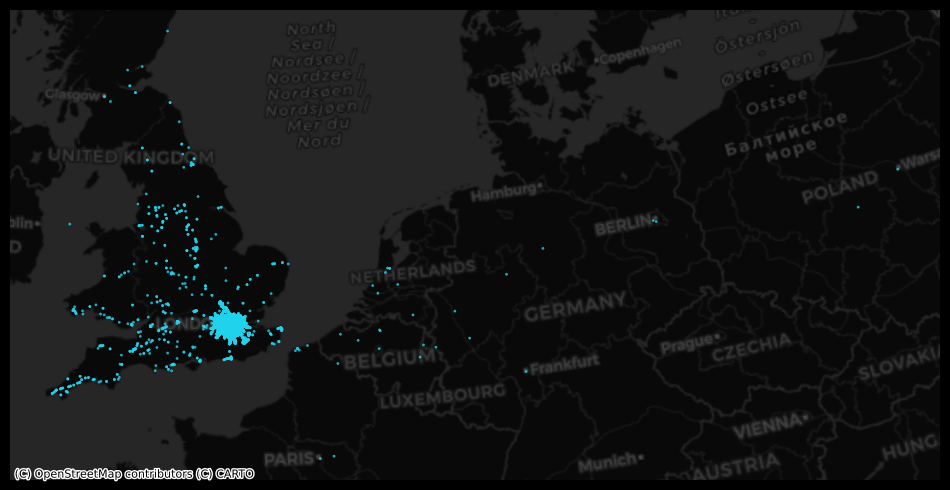

In [11]:
# Reproject to British National Grid for accurate distance calculations
stops_gdf_bng = gtfs_data['stops'].to_crs(epsg=27700)

# Visualize using c2g.plot_graph
print("Visualizing London's Transit Network")
ax = c2g.plot_graph(
    nodes=stops_gdf_bng,
)
ctx.add_basemap(ax, crs=stops_gdf_bng.crs, source=ctx.providers.CartoDB.DarkMatter)
plt.show()


## 3. Creating Transit Graphs with City2Graph

### The Power of Graph Representation
Raw GTFS data contains thousands of individual trips and stop times, but what we really want to understand are the **connections** and **flow patterns** in the network. This is where City2Graph shines - it transforms complex scheduling data into clean graph representations.

After loading the GTFS, `travel_summary_graph()` can summarize the trips between stops. The output contains the origin and destination of stops, with average travel times in seconds and frequency in the specified time intervals.

**What it does:**
- Processes thousands of individual trips into meaningful connections between stops
- Calculates **average travel times** between consecutive stops
- Counts **service frequency** (how often services run between stop pairs)
- Creates **spatial geometries** for each connection
- Handles **complex scheduling** including service calendars and time-of-day filtering

**Why this matters:**
- Transforms scheduling complexity into simple origin-destination relationships
- Enables network analysis (shortest paths, centrality, accessibility)
- Perfect input for graph neural networks and machine learning
- Ready-to-use format for visualization and spatial analysis

Let's see this powerful transformation in action:

In [12]:
# Transform GTFS schedules into a travel network graph
travel_summary_nodes, travel_summary_edges = c2g.travel_summary_graph(
    gtfs_data, 
    calendar_start="20250601",  # Analyze services for June 1, 2025
    calendar_end="20250601"     # Single day analysis for demonstration
)

travel_summary_nodes = travel_summary_nodes.to_crs(epsg=27700)
travel_summary_edges = travel_summary_edges.to_crs(epsg=27700)

print(f"Created graph with:")
print(f"   • {len(travel_summary_nodes):,} nodes (stops with connections)")
print(f"   • {len(travel_summary_edges):,} edges (stop-to-stop connections)")
print(f"   • Each edge contains travel time by seconds and frequency data")

Created graph with:
   • 24,745 nodes (stops with connections)
   • 28,133 edges (stop-to-stop connections)
   • Each edge contains travel time by seconds and frequency data


In [13]:
travel_summary_nodes.head()

stop_code                       stop_name  stop_lat  stop_lon  \
stop_id                                                                     
490014597S      48536  White Hart Ln Grt Cambridge Rd  51.60490 -0.085950   
490007372S      74106                 Granville Place  51.59650 -0.387280   
490013521E      52358                  The Ravensbury  51.39799 -0.157870   
240G006160A       NaN                     Bus Station  51.27127  0.193303   
490007476V      56036     Palmers Green / Green Lanes  51.61252 -0.107100   

            wheelchair_boarding location_type parent_station platform_code  \
stop_id                                                                      
490014597S                    0             0            NaN           NaN   
490007372S                    0             0            NaN           NaN   
490013521E                    0             0            NaN           NaN   
240G006160A                   0             1            NaN           NaN   
490007476V                    0             0            NaN           NaN   

                                  geometry  
stop_id                                     
490014597S    POINT (532649.18 191297.571)  
490007372S   POINT (511803.342 189860.013)  
490013521E   POINT (528248.023 168160.434)  
240G006160A  POINT (553097.001 154742.187)  
490007476V    POINT (531162.667 192106.81)

In [14]:
# Examine the edges (connections) in our travel network
print("Network Edges (Transit Connections):")
print("Each row represents a direct connection between two stops")
print("\nKey metrics city2graph calculated:")
print("   • travel_time_sec: Average time to travel between stops (seconds)")
print("   • frequency: Number of services per day on this connection")
print("   • geometry: LineString for mapping and spatial analysis")

print(f"\nPerformance insight:")
print(f"   Fastest connection: {travel_summary_edges['travel_time_sec'].min():.0f} seconds")
print(f"   Busiest connection: {travel_summary_edges['frequency'].max():.0f} services/day")
print(f"   Average travel time: {travel_summary_edges['travel_time_sec'].mean():.0f} seconds")

travel_summary_edges.head()

Network Edges (Transit Connections):
Each row represents a direct connection between two stops

Key metrics city2graph calculated:
   • travel_time_sec: Average time to travel between stops (seconds)
   • frequency: Number of services per day on this connection
   • geometry: LineString for mapping and spatial analysis

Performance insight:
   Fastest connection: 1 seconds
   Busiest connection: 999 services/day
   Average travel time: 436 seconds


travel_time_sec  frequency  \
from_stop_id to_stop_id                                 
01000053216  0170SGP90689       830.303030       99.0   
             0190NSZ01231      2700.000000        8.0   
             035059860001      5541.176471       17.0   
             1100DEA57098      6600.000000        6.0   
             360000174         3710.000000       30.0   

                                                                    geometry  
from_stop_id to_stop_id                                                       
01000053216  0170SGP90689  LINESTRING (358898.332 173509.501, 362270.014 ...  
             0190NSZ01231  LINESTRING (358898.332 173509.501, 336803.818 ...  
             035059860001  LINESTRING (358898.332 173509.501, 471026.138 ...  
             1100DEA57098  LINESTRING (358898.332 173509.501, 292592.045 ...  
             360000174     LINESTRING (358898.332 173509.501, 325332.697 ...

Now we will clean up the dataset to focus on Greater London, excluding intercity and international lines. This time we employed the boundary of the Greater London by `osmnx`.

In [15]:
# Get London boundary using OSMnx
london_boundary = ox.geocode_to_gdf("Greater London, UK").to_crs(epsg=27700)

# Project our network data to British National Grid for accurate spatial operations
travel_summary_nodes = travel_summary_nodes.to_crs(epsg=27700)
travel_summary_edges = travel_summary_edges.to_crs(epsg=27700)

# Spatial join to filter data within London boundary
print("Filtering nodes and edges within London boundary...")
nodes_in_bound = gpd.sjoin(travel_summary_nodes, london_boundary, how="inner").drop(columns=['index_right'])
edges_in_bound = gpd.sjoin(travel_summary_edges, london_boundary, how="inner").drop(columns=['index_right'])

# Update variables and ensure edge consistency
travel_summary_nodes = nodes_in_bound
travel_summary_edges = edges_in_bound

# Keep only edges where both endpoints are in our filtered node set
travel_summary_edges = travel_summary_edges[
    travel_summary_edges.index.get_level_values('from_stop_id').isin(travel_summary_nodes.index) &
    travel_summary_edges.index.get_level_values('to_stop_id').isin(travel_summary_nodes.index)
]

print(f"Spatial filtering complete:")
print(f"   Nodes within London: {len(travel_summary_nodes):,}")
print(f"   Edges within London: {len(travel_summary_edges):,}")

Filtering nodes and edges within London boundary...
Spatial filtering complete:
   Nodes within London: 20,220
   Edges within London: 25,182


As a result, we can see the overview by `plot_graph()`.

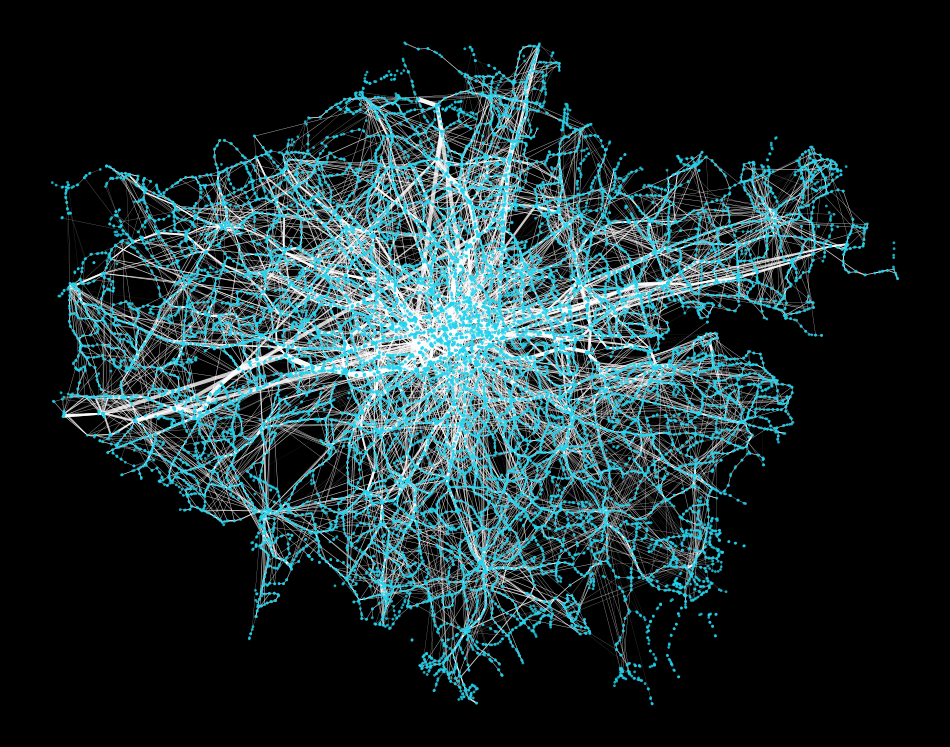

In [16]:
# Plot the network with dual encoding (color + width) using city2graph
c2g.plot_graph(
    nodes=travel_summary_nodes,
    edges=travel_summary_edges,
    edge_color='travel_time_sec',
    edge_linewidth=travel_summary_edges['frequency'] / 250,
    edge_alpha=0.8,
    )
plt.show()

## 4. Network Centrality Analysis

We can now visualize the network structure using the calculated betweenness centrality. Nodes with higher centrality (key hubs) will be highlighted with brighter colors, while edge thickness represents service frequency. This visualization helps identify the most critical stops and connections that serve as bridges in the London transit network.


For the calcluation of network centralities, `networkx` is not the fastest solution. `city2graph` provides conversion functionalies to `rustworkx` for better compuation efficiency by rust.

In [17]:
travel_summary_graph = c2g.gdf_to_nx(
    travel_summary_nodes,
    travel_summary_edges,
)

travel_rx_graph = c2g.nx_to_rx(travel_summary_graph)

betweenness_centrality = rx.betweenness_centrality(travel_rx_graph)

# Set the betweenness centrality as a node attribute
nx.set_node_attributes(
    travel_summary_graph,
    betweenness_centrality, 
    "betweenness_centrality"
    )

travel_nodes, travel_edges = c2g.nx_to_gdf(travel_summary_graph)

Removed 3 invalid geometries


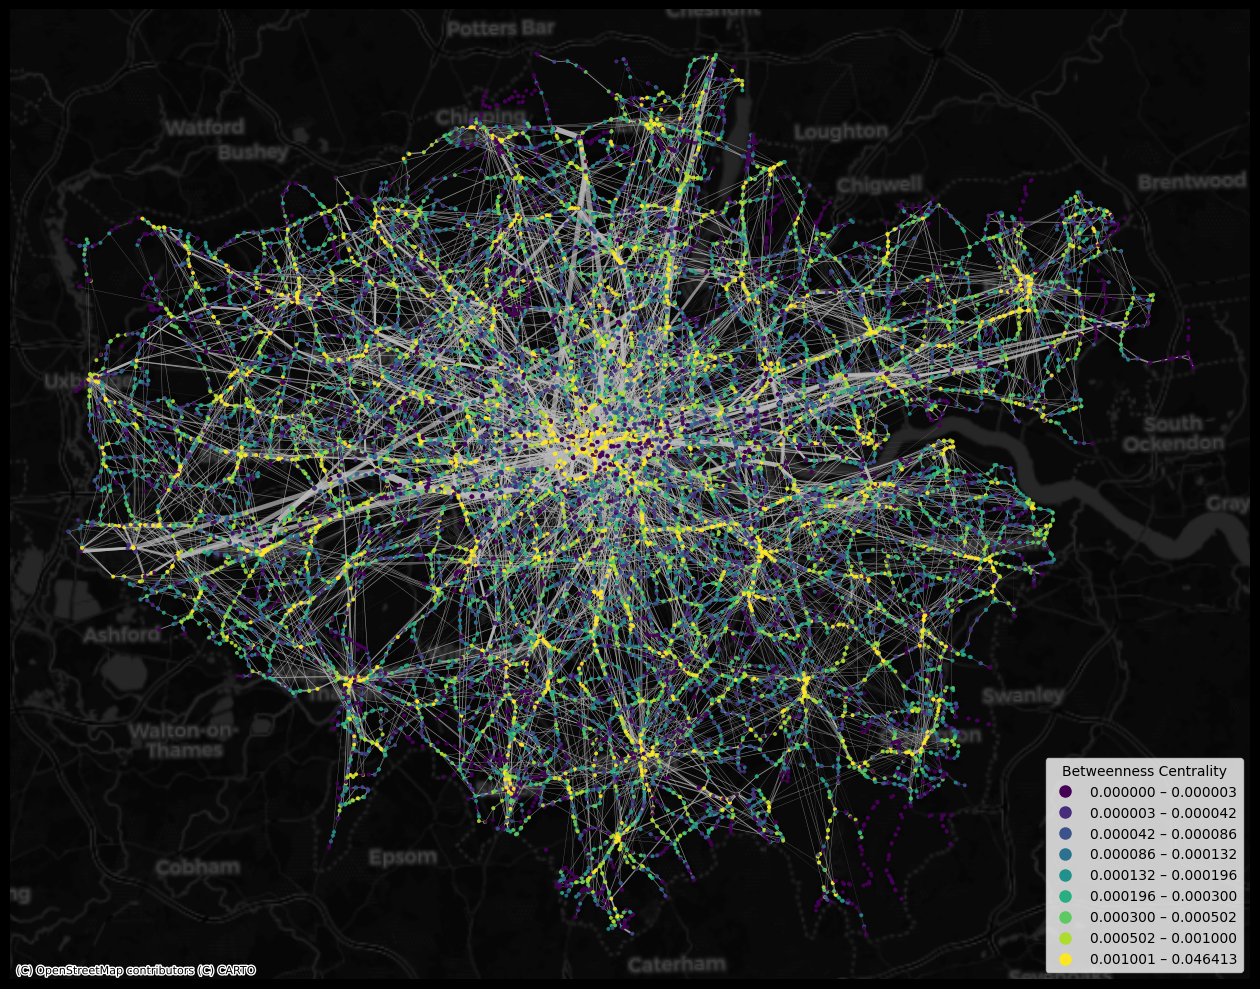

In [18]:
# Calculate quantiles for node size to handle skew in centrality values
# Drop duplicate bin edges to avoid qcut errors when many nodes share the same centrality
centrality_bins = pd.qcut(
    travel_nodes['betweenness_centrality'],
    q=10,
    labels=False,
    duplicates="drop"
)

travel_nodes['centrality_quantile'] = centrality_bins.fillna(0).astype(int) + 1
travel_nodes['node_size_visual'] = travel_nodes['centrality_quantile'] * 15

fig, ax = plt.subplots(figsize=(16, 16))

# Use city2graph to plot the network structure
# Node size represents centrality (skews handled by quantiles)
# Edge width represents frequency
c2g.plot_graph(
    nodes=travel_nodes,
    edges=travel_edges,
    markersize=8,
    node_color='centrality_quantile',
    node_alpha=0.9,
    edge_color='#bbbbbb',
    edge_linewidth=travel_edges['frequency'] / 200,
    edge_alpha=0.7,
    figsize=(16, 16),
    title="Central London Transit Network\nBetweenness Centrality of Stops",
    legend=True,
    legend_kwargs={'label': 'Betweenness Centrality', 'orientation': 'horizontal'},
    ax=ax
)

# Add legend for betweenness centrality ranges
cmap = plt.cm.viridis
norm = plt.Normalize(
    vmin=travel_nodes['centrality_quantile'].min(),
    vmax=travel_nodes['centrality_quantile'].max()
)

quantile_ranges = (
    travel_nodes
    .groupby('centrality_quantile')['betweenness_centrality']
    .agg(['min', 'max'])
    .reset_index()
)

handles = [
    mlines.Line2D(
        [],
        [],
        color=cmap(norm(row['centrality_quantile'])),
        marker='o',
        linestyle='',
        markersize=8,
        label=f"{row['min']:.6f} – {row['max']:.6f}"
    )
    for _, row in quantile_ranges.iterrows()
]
ax.legend(handles=handles, title='Betweenness Centrality', loc='lower right')

# Add basemap with a clean, modern style
ctx.add_basemap(ax, crs=travel_nodes.crs, source=ctx.providers.CartoDB.DarkMatter)

plt.show()

As seen in the plot, we could detect stations with higher betweenness centrality that are alongside of main streets.

To see the local property of transportation systems, we wil filter the graph using `filter_by_distance`. This time we filter it with 15-minute (900-seconds) travel tume from the central of London.

In [19]:
# Filter graph to show network within 1.2km of central London
center_point = london_boundary.geometry.to_crs(27700).iloc[0].centroid

filtered_travel_summary_graph = c2g.filter_graph_by_distance(
    travel_summary_graph,
    center_point=center_point,
    threshold=900,  # 900 seconds (~15 minutes travel tune)
    edge_attr="travel_time_sec"  # Filter by travel time, not physical distance
)

In [20]:
filtered_travel_rx_graph = c2g.nx_to_rx(filtered_travel_summary_graph)

betweenness_centrality_filtered = rx.betweenness_centrality(filtered_travel_rx_graph)

# Set the betweenness centrality as a node attribute
nx.set_node_attributes(
    filtered_travel_summary_graph,
    betweenness_centrality_filtered, 
    "betweenness_centrality"
    )

In [21]:
filtered_travel_nodes, filtered_travel_edges = c2g.nx_to_gdf(
    filtered_travel_summary_graph
    )

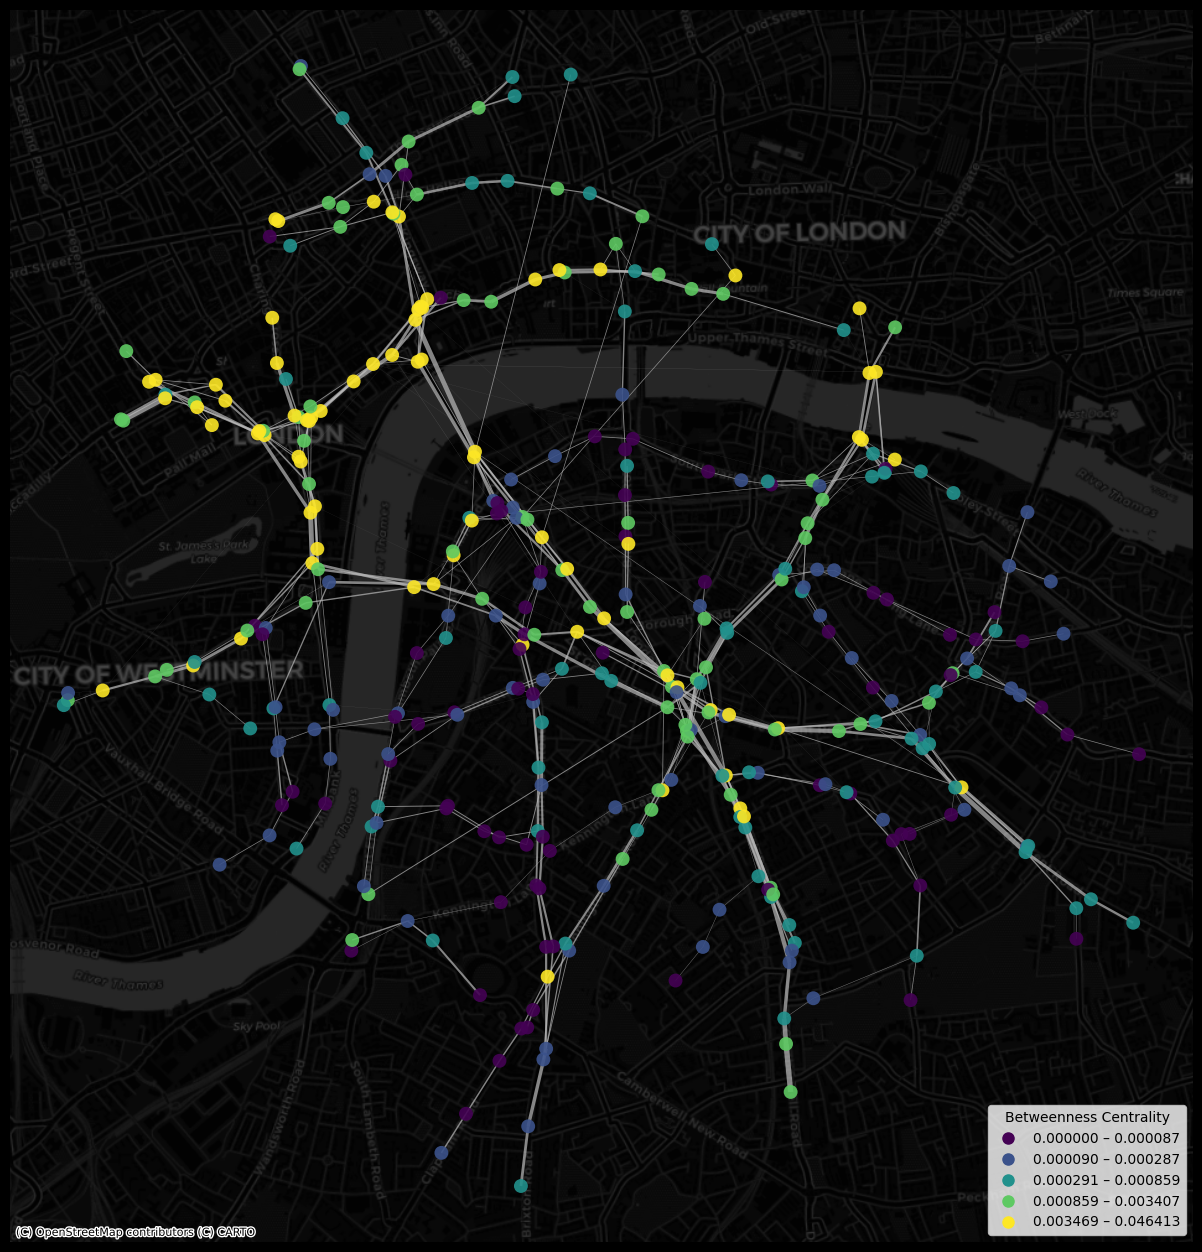

In [22]:
# Calculate quantiles for node size to handle skew in centrality values
# We bin the data into 5 quantiles and scale the size for visibility
filtered_travel_nodes['centrality_quantile'] = pd.qcut(
    filtered_travel_nodes['betweenness_centrality'], 
    q=5, 
    labels=False
) + 1
filtered_travel_nodes['node_size_visual'] = filtered_travel_nodes['centrality_quantile'] * 15

fig, ax = plt.subplots(figsize=(16, 16))

# Use city2graph to plot the network structure
# Node size represents centrality (skews handled by quantiles)
# Edge width represents frequency
c2g.plot_graph(
    nodes=filtered_travel_nodes,
    edges=filtered_travel_edges,
    node_color='centrality_quantile',
    markersize=100,
    node_alpha=0.9,
    edge_color='#bbbbbb',
    edge_linewidth=filtered_travel_edges['frequency'] / 200,
    edge_alpha=0.7,
    ax=ax
)

# Add basemap with a clean, modern style
ctx.add_basemap(ax, crs=filtered_travel_nodes.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add legend for betweenness centrality ranges
cmap = plt.cm.viridis
norm = plt.Normalize(
    vmin=filtered_travel_nodes['centrality_quantile'].min(),
    vmax=filtered_travel_nodes['centrality_quantile'].max()
)

quantile_ranges = (
    filtered_travel_nodes
    .groupby('centrality_quantile')['betweenness_centrality']
    .agg(['min', 'max'])
    .reset_index()
)

handles = [
    mlines.Line2D(
        [],
        [],
        color=cmap(norm(row['centrality_quantile'])),
        marker='o',
        linestyle='',
        markersize=8,
        label=f"{row['min']:.6f} – {row['max']:.6f}"
    )
    for _, row in quantile_ranges.iterrows()
]
ax.legend(handles=handles, title='Betweenness Centrality', loc='lower right')

plt.show()


## 6. Accessibility Analysis with Isochrones

### Understanding Isochrones
An **isochrone** is a contour line connecting points that are equally accessible (by travel time) from a given origin. In transportation networks, isochrones reveal the "reachability" from a central location - showing how far passengers can travel within a specific time limit.

**Why isochrones matter:**
- **Accessibility assessment** - Which neighborhoods are within 15 minutes of transit?
- **Equity analysis** - Identifying underserved areas with limited transit access
- **Urban planning** - Informing decisions about transit infrastructure investment
- **Station placement** - Understanding which locations serve the widest catchment

City2Graph's `create_isochrone()` function simplifies this complex spatial analysis, automatically:
1. Building travel time relationships from the transit network
2. Finding all reachable stops within a travel time threshold
3. Generating smooth boundary polygons around reachable areas
4. Supporting multiple polygon generation methods (concave hull, alpha shape, convex hull, buffer)
5. Supporting heterogeneous graphs with multimodal situation (bus, street, etc.)


In [35]:
print("Creating isochrones for accessibility analysis...")
print(f"Center point: {center_point}")
print("\nIsochrone parameters:")
print("  • Threshold: 1800 seconds (30 minutes travel time)")
print("  • Edge attribute: travel_time_sec (average seconds between stops)")
print("  • Method: concave_hull_knn (produces smooth, realistic boundaries)")

# Create isochrone showing 30-minute travel range
isochrone_30min = c2g.create_isochrone(
    graph=travel_summary_graph,
    center_point=center_point,
    threshold=1800,  # 30 minutes in seconds
    edge_attr="travel_time_sec"
    )

print(f"Reachable area geometry: {isochrone_30min.geometry.geom_type.iloc[0]}")
print(f"Area coverage: {isochrone_30min.geometry.area.iloc[0] / 1e6:.2f} km²")


Creating isochrones for accessibility analysis...
Center point: POINT (531330.9685805585 179645.93517953434)

Isochrone parameters:
  • Threshold: 1800 seconds (30 minutes travel time)
  • Edge attribute: travel_time_sec (average seconds between stops)
  • Method: concave_hull_knn (produces smooth, realistic boundaries)
Reachable area geometry: Polygon
Area coverage: 101.04 km²


In [24]:
time_thresholds = {
    '5 minutes' : 300,
    '10 minutes': 600,
    '15 minutes': 900,
}

isochrones = {}
for label, seconds in time_thresholds.items():
    iso = c2g.create_isochrone(
        graph=travel_summary_graph,
        center_point=center_point,
        threshold=seconds,
        edge_attr="travel_time_sec",
    )
    isochrones[label] = iso
    area_km2 = iso.geometry.area.iloc[0] / 1e6
    print(f"{label:15} → {area_km2:6.2f} km² reachable area")

5 minutes       →   0.42 km² reachable area
10 minutes      →   6.77 km² reachable area
15 minutes      →  18.85 km² reachable area


/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_85849/295802431.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize=12, framealpha=0.9)


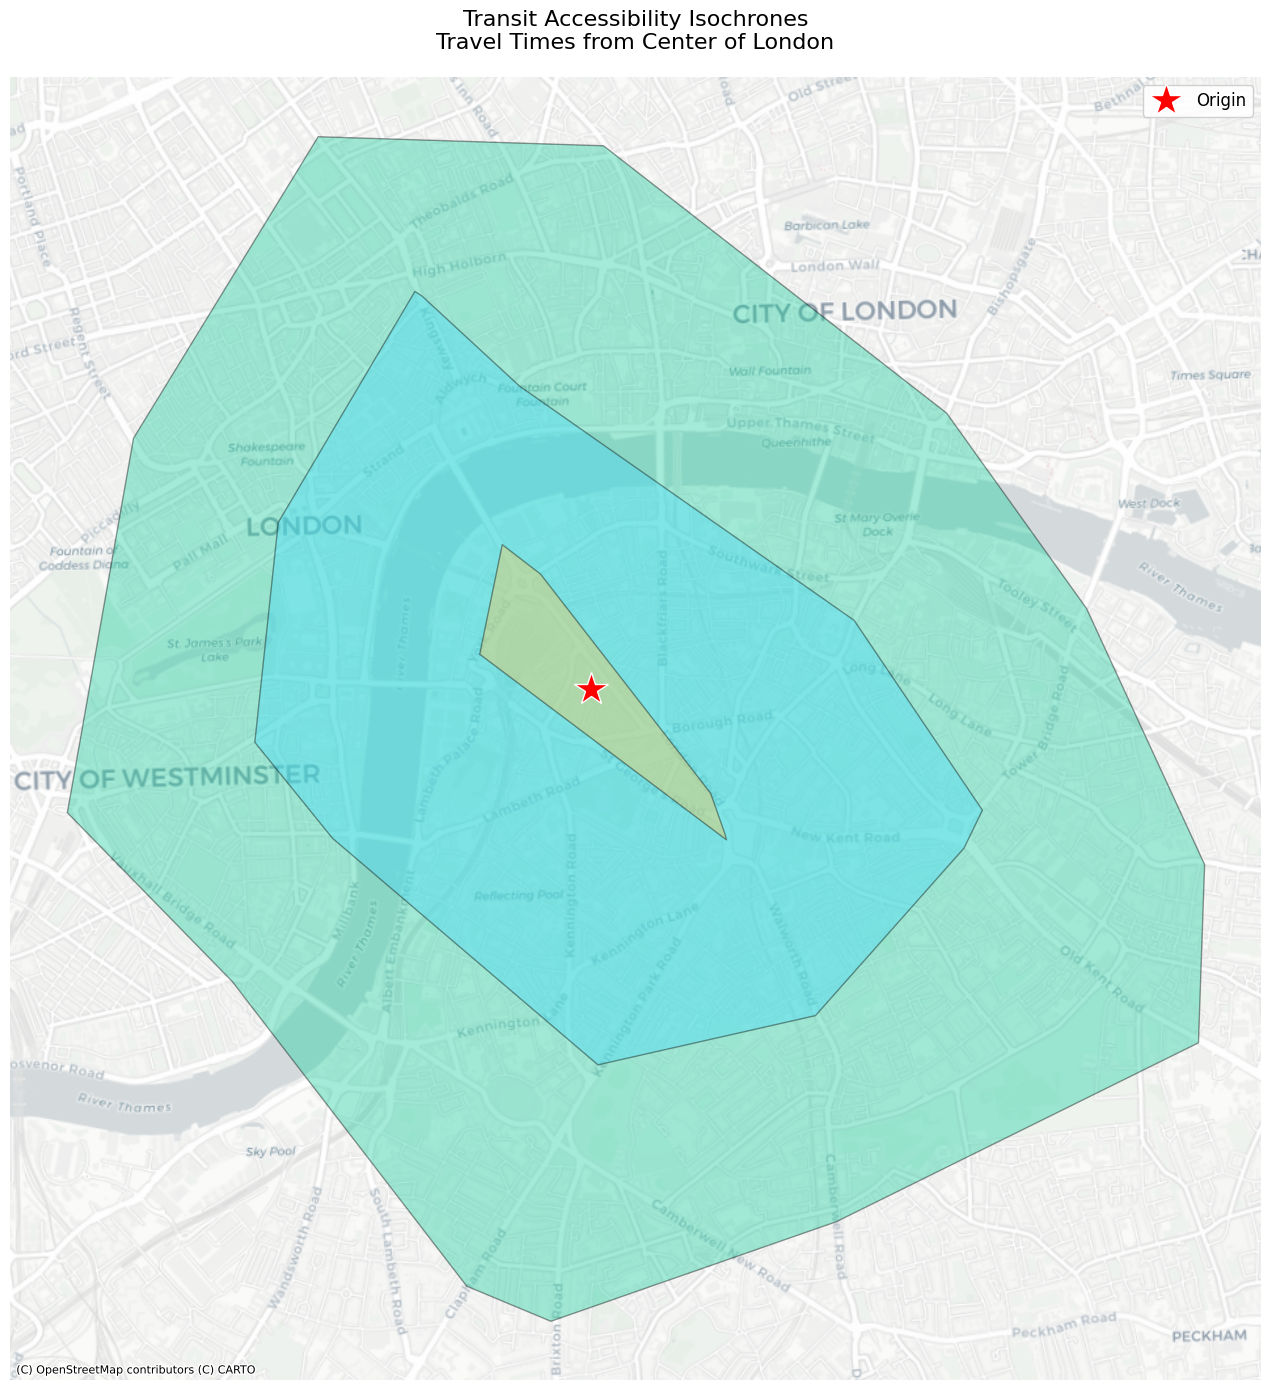

In [25]:
fig, ax = plt.subplots(figsize=(16, 14))

# Define colors for each isochrone (from cool to warm)
iso_colors = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1']
iso_labels = list(isochrones.keys())

# Plot isochrones from largest to smallest (so they don't overlap visually)
for label, color in zip(reversed(iso_labels), reversed(iso_colors)):
    iso_gdf = isochrones[label]
    iso_gdf.plot(
        ax=ax,
        alpha=0.4, # Increased alpha for better visibility
        color=color,
        label=label,
        edgecolor='black', # Changed edge color for contrast
        linewidth=1,
        zorder=2 # Ensure they sit above basemap but below network
    )

# Mark the center point
ax.plot(center_point.x, center_point.y, 'r*', markersize=25, markeredgecolor='white', label='Origin', zorder=10)

# Add basemap
ctx.add_basemap(ax, crs=travel_nodes.crs, source=ctx.providers.CartoDB.Positron)

ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
ax.set_title('Transit Accessibility Isochrones\nTravel Times from Center of London', 
             fontsize=16, color='black', pad=20)
ax.axis('off') # Cleaner look

plt.tight_layout()
plt.show()

### Isochrones on Street Networks (Walking Distance)

To see different accessibility by walking distance, we introduce streets network using `osmnx`.

In [26]:
print("Fetching London street network from OSM (walk network)...")
london_poly = london_boundary.to_crs(epsg=4326).geometry.union_all()

# Download pedestrian network for the London polygon
street_graph = ox.graph_from_polygon(london_poly, network_type="walk", simplify=True)

# Convert to GeoDataFrames
street_nodes, street_edges = c2g.nx_to_gdf(street_graph)

# Ensure correct CRS and reproject to British National Grid for distance calculations
street_nodes = street_nodes.set_crs(epsg=4326).to_crs(epsg=27700)
street_edges = street_edges.set_crs(epsg=4326).to_crs(epsg=27700)

# Recompute accurate lengths in metres using projected geometries
street_edges["length"] = street_edges.geometry.length

# Compute walking travel time (seconds) assuming 4.5 km/h = 4500 m/h
street_edges["travel_time_sec"] = street_edges["length"] / 4500 * 3600

# Basic summary for verification
print(f"Street nodes: {len(street_nodes):,}")
print(f"Street edges: {len(street_edges):,}")
print("Sample street edges:")
display(street_edges.head())

Fetching London street network from OSM (walk network)...
Street nodes: 492,210
Street edges: 1,264,518
Sample street edges:


osmid      access       highway maxspeed  \
78112 25508583    0  129375498  permissive  unclassified   20 mph   
      25508584    0  129375498  permissive  unclassified   20 mph   
                  1    4257258  permissive   residential   20 mph   
99884 12378884761 0    4082681         NaN       footway      NaN   
      4544836450  0    5090291         NaN       footway      NaN   

                                  name  oneway reversed      length  \
78112 25508583    0       Outer Circle   False    False   19.399136   
      25508584    0       Outer Circle   False     True   63.701486   
                  1  Cambridge Terrace   False    False  102.844507   
99884 12378884761 0                NaN   False    False  173.282760   
      4544836450  0                NaN   False    False  308.182017   

                                                              geometry bridge  \
78112 25508583    0  LINESTRING (528725 182525.235, 528726.116 1825...    NaN   
      25508584    0  LINESTRING (528725 182525.235, 528722.54 18258...    NaN   
                  1  LINESTRING (528725 182525.235, 528744.582 1825...    NaN   
99884 12378884761 0  LINESTRING (528245.101 182222.468, 528259.75 1...    NaN   
      4544836450  0  LINESTRING (528245.101 182222.468, 528275.674 ...    NaN   

                    service lanes  ref tunnel width junction est_width area  \
78112 25508583    0     NaN   NaN  NaN    NaN   NaN      NaN       NaN  NaN   
      25508584    0     NaN   NaN  NaN    NaN   NaN      NaN       NaN  NaN   
                  1     NaN   NaN  NaN    NaN   NaN      NaN       NaN  NaN   
99884 12378884761 0     NaN   NaN  NaN    NaN   NaN      NaN       NaN  NaN   
      4544836450  0     NaN   NaN  NaN    NaN   NaN      NaN       NaN  NaN   

                     travel_time_sec  
78112 25508583    0        15.519308  
      25508584    0        50.961189  
                  1        82.275606  
99884 12378884761 0       138.626208  
      4544836450  0       246.545613

In [27]:
walking_thresholds = {
    '5 minutes' : 300,
    '10 minutes': 600,
    '15 minutes': 900
}

walking_isochrones = {}
for label, seconds in walking_thresholds.items():
    iso = c2g.create_isochrone(
        nodes=street_nodes,
        edges=street_edges,
        center_point=center_point,
        threshold=seconds,
        edge_attr="travel_time_sec",
    )
    walking_isochrones[label] = iso
    area_km2 = iso.geometry.area.iloc[0] / 1e6
    print(f"{label:12} → {area_km2:6.2f} km² reachable area")


5 minutes    →   0.16 km² reachable area
10 minutes   →   0.88 km² reachable area
15 minutes   →   2.11 km² reachable area


/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_85849/2363295211.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', framealpha=0.9)


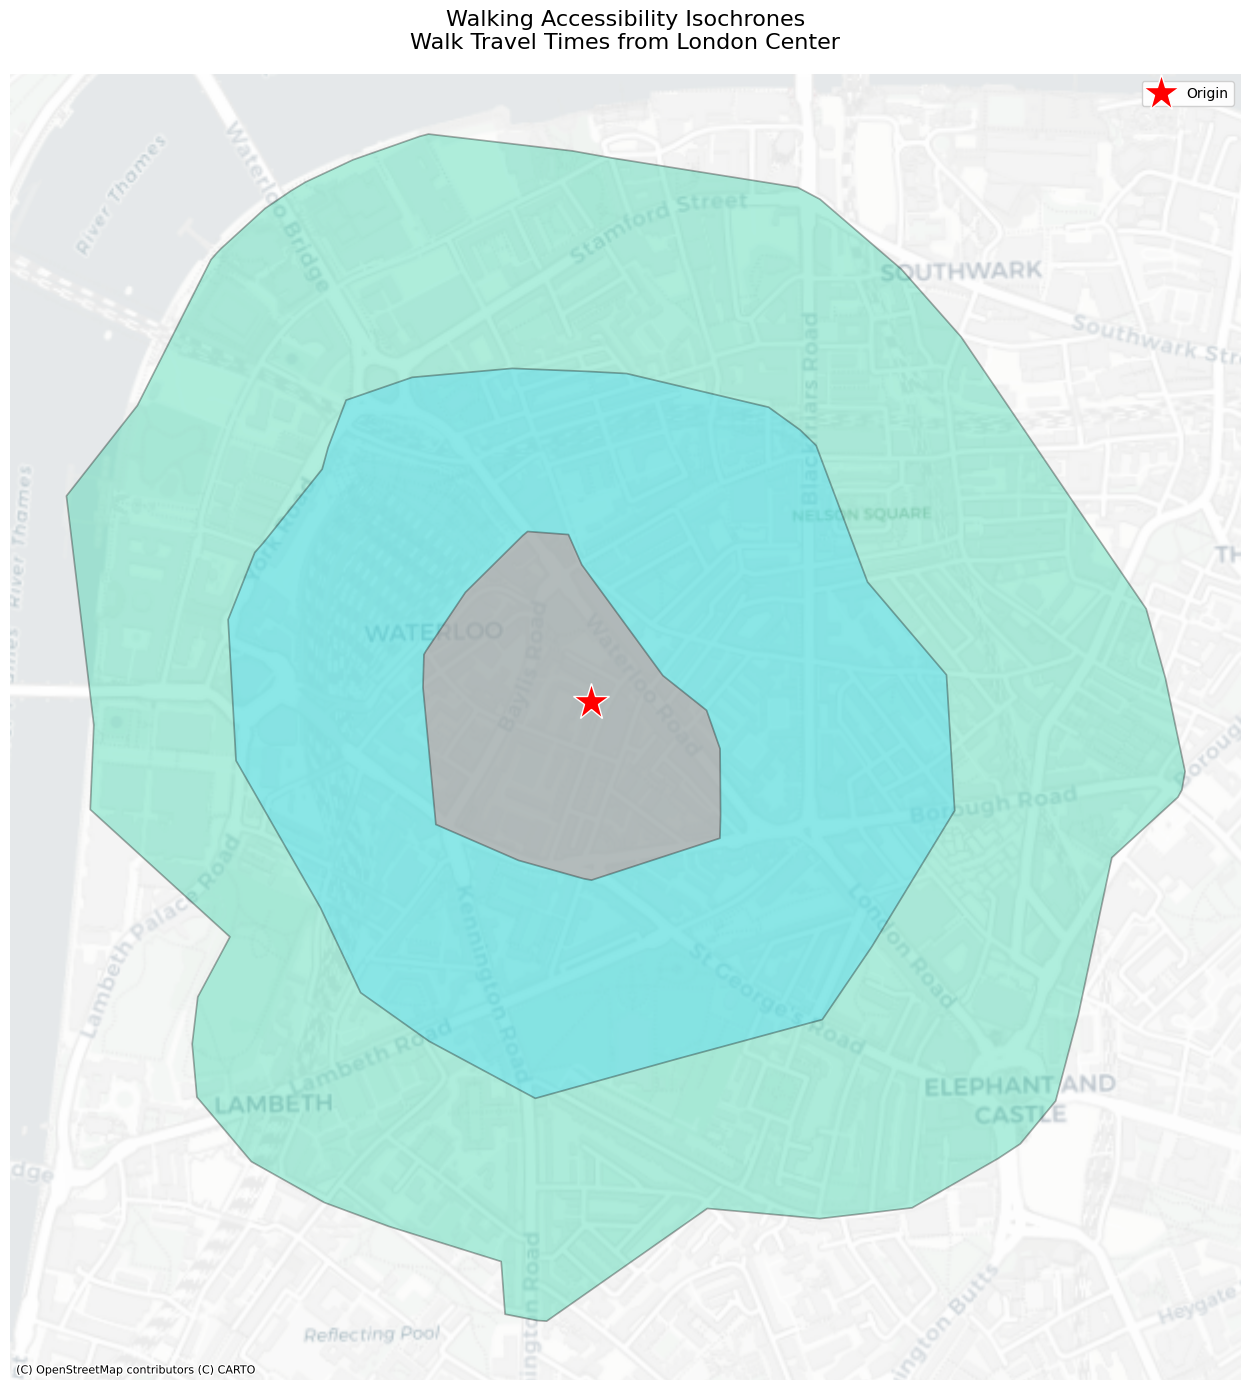

In [28]:
fig, ax = plt.subplots(figsize=(16, 14))

multi_colors = ['#ff6b6b', '#48dbfb', '#1dd1a1']
labels_ordered = list(walking_isochrones.keys())

# Plot larger thresholds first for layering
for label, color in zip(reversed(labels_ordered), reversed(multi_colors)):
    iso_gdf = walking_isochrones[label]
    iso_gdf.plot(
        ax=ax,
        alpha=0.35,
        color=color,
        edgecolor='#111111',
        linewidth=1.25,
        label=label,
        zorder=2,
    )

# Origin marker
ax.plot(center_point.x, center_point.y, 'r*', markersize=28, markeredgecolor='white', label='Origin', zorder=4)

# Basemap for context
ctx.add_basemap(ax, crs=travel_nodes.crs, source=ctx.providers.CartoDB.Positron, alpha=0.6)

ax.set_title('Walking Accessibility Isochrones\nWalk Travel Times from London Center', fontsize=16, color='black', pad=18)
ax.legend(loc='upper right', framealpha=0.9)
ax.axis('off')
plt.tight_layout()
plt.show()

### Isochrones on the Heterogeneous (Street + Transit) Graph

Now that we have a multimodal graph combining street intersections and bus stations, we can compute isochrones using `travel_time_sec` across all edge types. This shows walk-to-transit accessibility with realistic travel times.


In [29]:
hetero_nodes = {
    "street_intersection": street_nodes,
    "bus_station": travel_nodes,
}

hetero_edges = {
    ("street_intersection", "is_connected_to", "street_intersection"): street_edges,
    ("bus_station", "is_next_to", "bus_station"): travel_edges,
}

In [30]:
_, bridged_edges = c2g.bridge_nodes(hetero_nodes, source_node_types=["bus_station"])

bridged_edges[('bus_station', 'is_nearby', 'street_intersection')]["travel_time_sec"] = bridged_edges[('bus_station', 'is_nearby', 'street_intersection')].geometry.length / 4500 * 3600

hetero_edges.update(bridged_edges)

In [31]:
multimodal_thresholds = {
    '5 minutes' : 300,
    '10 minutes': 600,
    '15 minutes': 900
}

multimodal_isochrones = {}
for label, seconds in multimodal_thresholds.items():
    iso = c2g.create_isochrone(
        nodes=hetero_nodes,
        edges=hetero_edges,
        center_point=center_point,
        threshold=seconds,
        edge_attr="travel_time_sec",
    )
    multimodal_isochrones[label] = iso
    area_km2 = iso.geometry.area.iloc[0] / 1e6
    print(f"{label:12} → {area_km2:6.2f} km² reachable area")


5 minutes    →   0.25 km² reachable area
10 minutes   →   3.30 km² reachable area
15 minutes   →  15.77 km² reachable area


/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_85849/3780161585.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', framealpha=0.9)


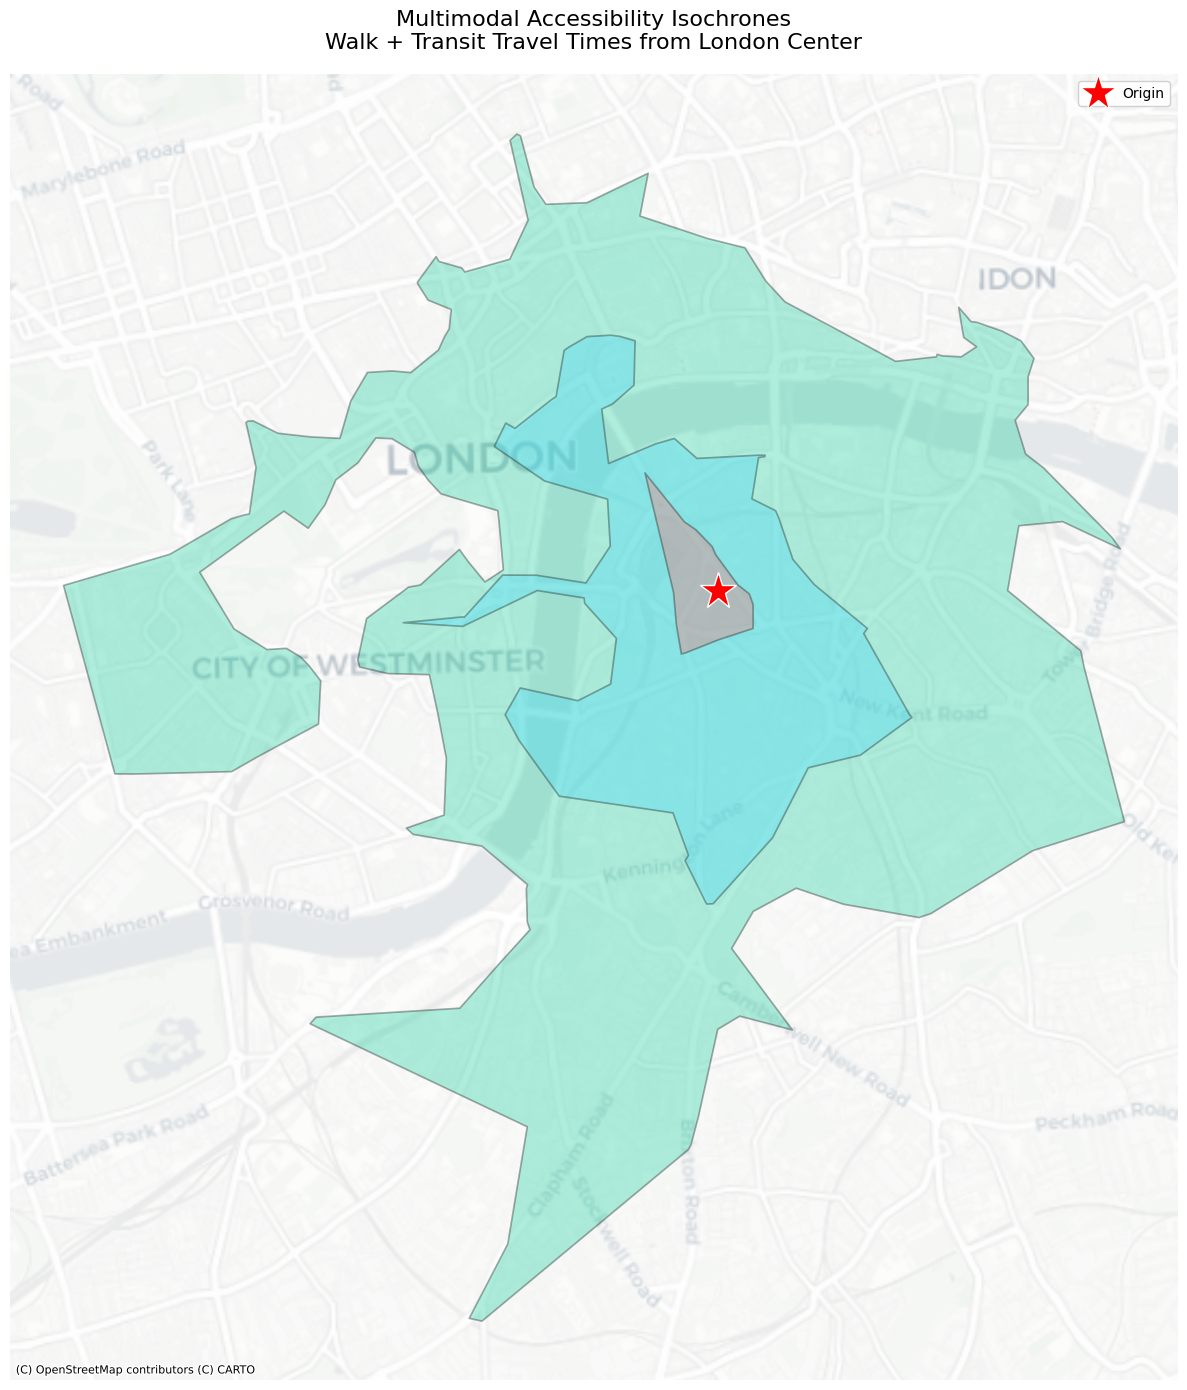

In [32]:
fig, ax = plt.subplots(figsize=(16, 14))

multi_colors = ['#ff6b6b', '#48dbfb', '#1dd1a1']
labels_ordered = list(multimodal_isochrones.keys())

# Plot larger thresholds first for layering
for label, color in zip(reversed(labels_ordered), reversed(multi_colors)):
    iso_gdf = multimodal_isochrones[label]
    iso_gdf.plot(
        ax=ax,
        alpha=0.35,
        color=color,
        edgecolor='#111111',
        linewidth=1.25,
        label=label,
        zorder=2,
    )

# Origin marker
ax.plot(center_point.x, center_point.y, 'r*', markersize=28, markeredgecolor='white', label='Origin', zorder=4)

# Basemap for context
ctx.add_basemap(ax, crs=travel_nodes.crs, source=ctx.providers.CartoDB.Positron, alpha=0.6)

ax.set_title('Multimodal Accessibility Isochrones\nWalk + Transit Travel Times from London Center', fontsize=16, color='black', pad=18)
ax.legend(loc='upper right', framealpha=0.9)
ax.axis('off')
plt.tight_layout()
plt.show()